In [114]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import gradio as gr

In [115]:
DIR = "C:\\Users\\Akhil\\micron\\trashnet-master\\data\\dataset-resized\\dataset-resized"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

Found 2562 files belonging to 7 classes.
Using 2306 files for training.
Found 2562 files belonging to 7 classes.
Using 256 files for validation.


In [116]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['bulk_trial', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [117]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

In [118]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/50


C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


19/19 [==============================] - 120s 6s/step - loss: 322.9219 - accuracy: 0.4545 - val_loss: 215.8448 - val_accuracy: 0.7266
Epoch 2/50
19/19 [==============================] - 115s 6s/step - loss: 156.4590 - accuracy: 0.7541 - val_loss: 95.8393 - val_accuracy: 0.7617
Epoch 3/50
19/19 [==============================] - 112s 6s/step - loss: 63.7691 - accuracy: 0.8057 - val_loss: 33.6747 - val_accuracy: 0.7812
Epoch 4/50
19/19 [==============================] - 114s 6s/step - loss: 20.4817 - accuracy: 0.8122 - val_loss: 9.9821 - val_accuracy: 0.7695
Epoch 5/50
19/19 [==============================] - 115s 6s/step - loss: 7.3173 - accuracy: 0.7715 - val_loss: 5.6196 - val_accuracy: 0.6172
Epoch 6/50
19/19 [==============================] - 116s 6s/step - loss: 5.0035 - accuracy: 0.6925 - val_loss: 4.9642 - val_accuracy: 0.6367
Epoch 7/50
19/19 [==============================] - 115s 6s/step - loss: 4.8461 - accuracy: 0.7212 - val_loss: 4.7148 - val_accuracy: 0.6445
Epoch 8/50
19/

In [154]:
model.save("/content/model.h5")

In [119]:
dump=[]

In [140]:
path = "C:\\Users\\Akhil\\micron\\trashnet-master\\data\\dataset-resized\\dataset-resized\\metal\\metal30.jpg"

def predict(input_image):
    img_array = tf.keras.preprocessing.image.img_to_array(input_image)
    img_array = tf.expand_dims(img_array, 0) 
    predictions = model.predict(img_array)
    predictions_arr=predictions.tolist()
    predictions_arr=predictions_arr[0]
    class_ind=(predictions_arr.index(max(predictions_arr)))
    dump.append(classes[class_ind])
    if classes[class_ind]=="plastic":
        return (classes[class_ind]),"It is Non-Biodegradable"
    else:
        return (classes[class_ind]),"It is Biodegradable"

In [141]:
demo = gr.Interface(predict, gr.Image(shape=(256, 256)), outputs=["text", "text"],examples=["plastic.jpg", "paper.jpg","glass.jpg"])
demo.launch()

Running on local URL:  http://127.0.0.1:7894

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x2006c5d9940>, 'http://127.0.0.1:7894/', None)

1/1 [==============================] - 0s 151ms/step


In [122]:
total=len(dump)
non_deg=0
deg=0
for i in dump:
    if (i=='plastic'):
        non_deg+=1
    else:
        deg+=1
non_deg_per=((non_deg)/total)*100
deg_per=((deg)/total)*100
non_deg_per=round(non_deg_per,2)
deg_per=round(deg_per,2)
print(f'Percentage of Non-Biodegradable waste: {non_deg_per}%')
print(f'Percentage of Biodegradable waste    : {deg_per}%')

Percentage of Non-Biodegradable waste: 14.29%
Percentage of Biodegradable waste    : 85.71%


In [170]:
import matplotlib.pyplot as plt

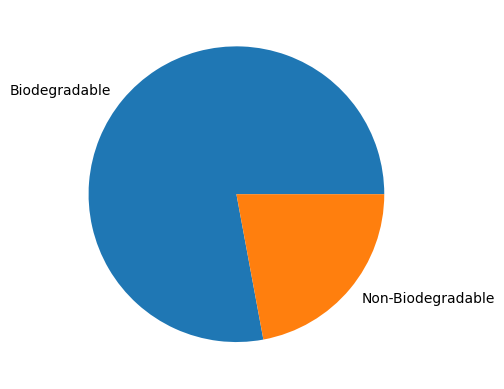

In [186]:
def predict_bulk(folder_path):
    dump_bulk=[]
    ret=[]
    files=os.listdir(folder_path)
    for i in files:
        file_path=folder_path+"\\"+i
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(256, 256))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) 
        predictions = model.predict(img_array)
        predictions_arr=predictions.tolist()
        predictions_arr=predictions_arr[0]
        class_ind=(predictions_arr.index(max(predictions_arr)))
        dump_bulk.append(classes[class_ind])
    total=len(dump_bulk)
    non_deg=0
    deg=0
    for i in dump_bulk:
        if (i=='plastic'):
            non_deg+=1
        else:
            deg+=1
    non_deg_per=((non_deg)/total)*100
    deg_per=((deg)/total)*100
    non_deg_per=round(non_deg_per,2)
    deg_per=round(deg_per,2)
    repeats=[[x,dump_bulk.count(x)] for x in set(dump_bulk)]
    ret.append(f'Percentage of Non-Biodegradable waste: {non_deg_per}%')
    ret.append(f'Percentage of Biodegradable waste    : {deg_per}%')
    temp=""
    repeat_keys=[]
    repeat_values=[]
    deg_keys=['Biodegradable','Non-Biodegradable']
    deg_values=[deg_per,non_deg_per]
    for i in range(len(repeats)):
        temp+=f'Number of {repeats[i][0]} materials: {repeats[i][1]}' +"\n"
        repeat_keys.append(repeats[i][0])
        repeat_values.append(repeats[i][1])
    #et.append(dump_bulk)
    plt.clf()
    plt.pie(repeat_values, labels=repeat_keys)
    plt.savefig('types_pie_chart.png')
    plt.clf()
    plt.pie(deg_values, labels=deg_keys)
    plt.savefig('deg_pie_chart.png')
    return ret[0],ret[1],temp,'types_pie_chart.png','deg_pie_chart.png'
    

In [ ]:
"""
C:\\Users\\Akhil\\micron\\trashnet-master\\data\\dataset-resized\\dataset-resized\\bulk_trial
"""

In [194]:
demo2 = gr.Interface(predict_bulk,inputs=gr.Textbox(lines=2, placeholder="Path here"),outputs=["text", "text", "text","image","image"])
demo2.launch(share=True)

Running on local URL:  http://127.0.0.1:7917
Running on public URL: https://0d32cd88db9e63f5.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x2006bc45af0>,
 'http://127.0.0.1:7917/',
 'https://0d32cd88db9e63f5.gradio.app')

1/1 [==============================] - 0s 123ms/step


In [112]:
from collections import Counter

words = ['cardboard', 'cardboard', 'cardboard', 'paper', 'cardboard', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'glass', 'plastic', 'paper', 'paper', 'plastic', 'paper', 'paper', 'glass', 'plastic', 'plastic', 'plastic', 'glass', 'plastic', 'glass', 'glass', 'plastic', 'plastic', 'plastic', 'glass', 'plastic', 'plastic', 'paper']

print(Counter(words).keys() )# equals to list(set(words))
print(Counter(words).values()) # counts the elements' frequency

dict_keys(['cardboard', 'paper', 'glass', 'plastic'])
dict_values([4, 6, 14, 11])
